In [1]:
import numpy as np
from bb_exponential import ExponentialBlocks_Events, test_bb_exp
from astropy.stats import bayesian_blocks
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.auto import tqdm
import os
from multiprocessing import Pool
from itertools import repeat

/nix/store/8qipyzpsb65dlribryvlbmfg9ah5b16x-python3-3.10.13-env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Per ottimizzare la scelta di ncp_prior in funzione di N (sum(x)) e p_0 (false detection rate) si procede come da Scargle 2.7:
0) si scelgono degli ncp_prior da testare
1) costruzione di un generatore che mi generi dati provenienti da rumore che in media siano sum=N
2) iterativamente si genera il rumore e si prova il fitting con dei valori di ncp_prior e si salva il numero di blocchi identificati in un array
3) abbiamo così l'array che in posizione i,j ha il numero di blocchi identificati dall'algoritmo con il rumore generato al passo i e con j-esimo ncp_prior
4) per ogni colonna dell'array calcoliamo p_0, ovvero (# casi con più blocchi identificati che 1)/(# casi totali)
5) si sceglie l'ncp_prior più basso (così il metodo è più sensibile) tale che il p_0 associato sia minore del treshold scelto all'inizio (il p_0 di input)

In [2]:
def generator(t,gamma):
    while True:
        x = np.random.poisson(125,len(t))
        idx = np.random.poisson(100)
        y = np.concatenate([np.zeros(idx),np.floor(gamma*np.exp(-np.linspace(0,20,1000)))[:1000-idx]])
        x=x+y
        yield x

/home/tirocinio/Codice/tirocinio/BBexponential/bb_exponential.py:252: RuntimeWarning: overflow encountered in exp
  return N_k*(np.log((a*N_k)/(1-np.exp(-a*T_k)))+a*S_k-1)
/home/tirocinio/Codice/tirocinio/BBexponential/bb_exponential.py:252: RuntimeWarning: divide by zero encountered in log
  return N_k*(np.log((a*N_k)/(1-np.exp(-a*T_k)))+a*S_k-1)
/nix/store/8qipyzpsb65dlribryvlbmfg9ah5b16x-python3-3.10.13-env/lib/python3.10/site-packages/scipy/optimize/_zeros_py.py:467: RuntimeWarning: some failed to converge after 50 iterations
  warnings.warn(msg, RuntimeWarning)


array([  0. , 110.5, 247.5, 999. ])

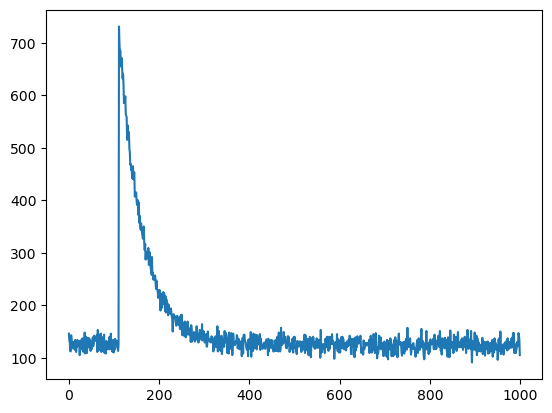

In [4]:
t = np.arange(1000)
gen = generator(t,600)
x = next(gen)
plt.plot(x)
bayesian_blocks(t,x,fitness=ExponentialBlocks_Events,ncp_prior=700)

In [5]:
def num_blocks(t,x,ncp_prior_list,fitness):
    arr = np.zeros_like(ncp_prior_list)
    for i in range(len(ncp_prior_list)):
        edg = bayesian_blocks(t,x,fitness=fitness,ncp_prior=ncp_prior_list[i])
        n_edges = len(edg)
        n_blocks = n_edges - 1
        #print(n_blocks)
        arr[i] = n_blocks
    return arr

In [6]:
def ncp_optimizer(t,gamma,ncp_prior_list,fitness,n_iter=10):
    gen = generator(t,gamma)
    arr = np.zeros((n_iter,len(ncp_prior_list)))
    for i in tqdm(range(n_iter)):
        x = next(gen)
        arr[i] = num_blocks(t,x,ncp_prior_list,fitness)
    arr[arr != 3] = 1
    arr[arr == 3] = 0
    mean_array = np.mean(arr,axis=0)
    return mean_array
    #tmp = np.where(mean_array < p_0)[0]
    #if tmp.size == 0:
    #    return None,mean_array
    #opt_index = tmp[0]
    #return ncp_prior_list[opt_index],mean_array

In [7]:
t=np.arange(500)
gamma=600
ncp_prior_list = np.linspace(1000,1100,2)
#num_blocks(t,x,ncp_prior_list,fitness = ExponentialBlocks_Events_Alt_2)
#ncp_optimizer(t,gamma,ncp_prior_list,0.1,fitness = ExponentialBlocks_Events_Alt_2,n_iter=10)

In [8]:
'''
gammas = np.linspace(389.47368421052636,2000,18)
ncp_prior_list = np.linspace(400,1600,20)
t = np.arange(500)
n_iter = 50

#columns = ['gamma'] + ['p_0(ncp='+str(ncp)+')' for ncp in ncp_prior_list] + ['n_iter']
#df = pd.DataFrame(columns = columns)
df = pd.read_csv('ncp.csv')
for gamma in gammas:
    print(f'esecuzione con parametro gamma={gamma}')
    p_0_array = ncp_optimizer(t,gamma,ncp_prior_list,fitness = ExponentialBlocks_Events_Alt_2,n_iter=n_iter)
    df.loc[len(df)] = np.concatenate([np.array([gamma]),p_0_array,np.array([n_iter])])
    df.to_csv('ncp.csv', index = False)
'''

"\ngammas = np.linspace(389.47368421052636,2000,18)\nncp_prior_list = np.linspace(400,1600,20)\nt = np.arange(500)\nn_iter = 50\n\n#columns = ['gamma'] + ['p_0(ncp='+str(ncp)+')' for ncp in ncp_prior_list] + ['n_iter']\n#df = pd.DataFrame(columns = columns)\ndf = pd.read_csv('ncp.csv')\nfor gamma in gammas:\n    print(f'esecuzione con parametro gamma={gamma}')\n    p_0_array = ncp_optimizer(t,gamma,ncp_prior_list,fitness = ExponentialBlocks_Events_Alt_2,n_iter=n_iter)\n    df.loc[len(df)] = np.concatenate([np.array([gamma]),p_0_array,np.array([n_iter])])\n    df.to_csv('ncp.csv', index = False)\n"

In [9]:
def mult_helper(t,gamma,ncp_prior_list,fitness,n_iter):
    #print(gamma)
    p_0_array = ncp_optimizer(t,gamma,ncp_prior_list,fitness = fitness,n_iter=n_iter)
    return np.concatenate([np.array([gamma]),p_0_array,np.array([n_iter])])

In [ ]:
gammas = np.linspace(400,2000,5)
ncp_prior_list = np.linspace(400,2000,4)
t = np.arange(1000)
n_iter = 1

if os.path.exists('ncp.csv'):
    df = pd.read_csv('ncp.csv')
else:
    columns = ['gamma'] + ['p_0(ncp='+str(ncp)+')' for ncp in ncp_prior_list] + ['n_iter']
    df = pd.DataFrame(columns = columns)

data = zip(repeat(t),gammas,repeat(ncp_prior_list),repeat(ExponentialBlocks_Events),repeat(n_iter))

with Pool(5) as p:
    results = p.starmap(mult_helper,data)
print(results)
for row in results:
    df.loc[len(df)] = row
df.to_csv('ncp.csv',index = False)

Tempo di Calcolo: 17.423430681228638
Estremi: [  0.  107.5 219.5 999. ]
Blocco 0: a=-0.001290015240742729,gamma=117.96822361890985
Blocco 1: a=-0.005154786025772113,gamma=122.16514573978738
Blocco 2: a=-4.657900052208626e-05,gamma=123.40392732786205


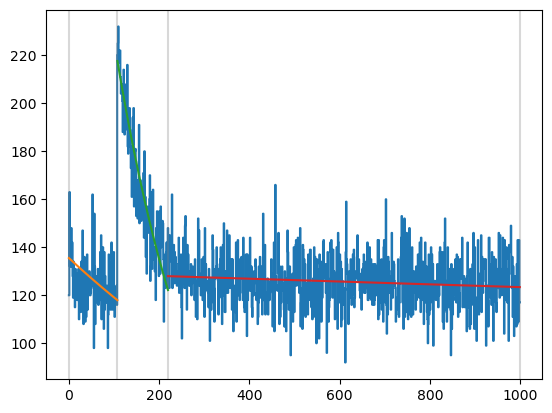

Tempo di Calcolo: 21.272127866744995
Estremi: [  0.  121.5 231.5 999. ]
Blocco 0: a=-0.00044929150746283536,gamma=123.45703395062593
Blocco 1: a=-0.005214004838375967,gamma=122.80739960795985
Blocco 2: a=-4.8503912628586024e-05,gamma=123.63729470279489


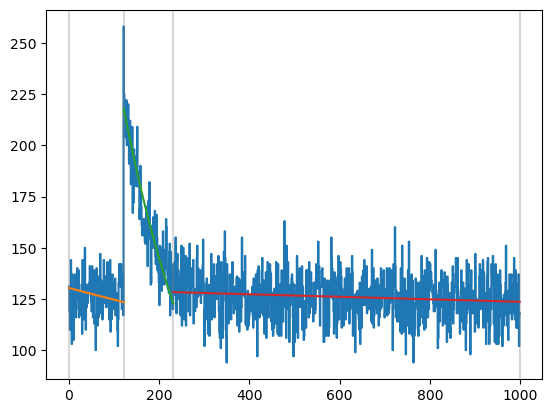

In [10]:
t = np.arange(1000)
gen = generator(t,100)
x = next(gen)
test_bb_exp(t,x,ExponentialBlocks_Events,ncp_prior=280)
x = next(gen)
test_bb_exp(t,x,ExponentialBlocks_Events,ncp_prior=280)

In [11]:
def N_calc(gamma):
    t = np.arange(1000)
    gen = generator(t,gamma)
    arr = np.zeros(10000)
    for i in range(10000):
        x = next(gen)
        arr[i]=sum(x)
    return np.mean(arr),np.std(arr)

100%|███████████████████████████████████████████| 40/40 [02:23<00:00,  3.58s/it]

[ 100.          148.71794872  197.43589744  246.15384615  294.87179487
  343.58974359  392.30769231  441.02564103  489.74358974  538.46153846
  587.17948718  635.8974359   684.61538462  733.33333333  782.05128205
  830.76923077  879.48717949  928.20512821  976.92307692 1025.64102564
 1074.35897436 1123.07692308 1171.79487179 1220.51282051 1269.23076923
 1317.94871795 1366.66666667 1415.38461538 1464.1025641  1512.82051282
 1561.53846154 1610.25641026 1658.97435897 1707.69230769 1756.41025641
 1805.12820513 1853.84615385 1902.56410256 1951.28205128 2000.        ]
[129889.3401 132325.2013 134778.9462 137238.5391 139690.3034 142152.0259
 144594.9395 147055.1928 149510.3874 151952.7083 154415.5738 156871.5114
 159323.4892 161794.0622 164248.6681 166696.6061 169161.0855 171607.956
 174064.6384 176523.809  178983.9768 181437.1534 183889.7991 186349.1523
 188813.8953 191267.5696 193731.0923 196189.1462 198639.4828 201090.5342
 203558.043  206006.9088 208467.6499 210923.3133 213385.0781 215843

<ErrorbarContainer object of 3 artists>

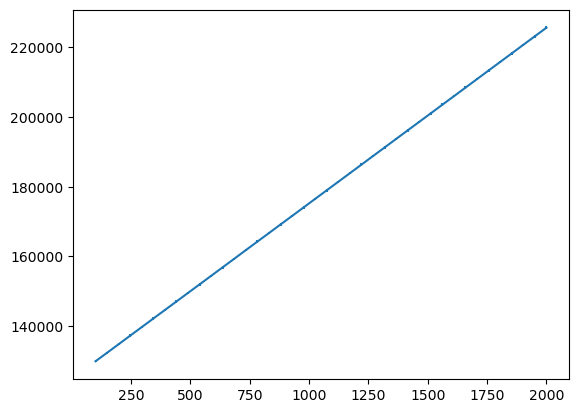

In [12]:
plot_t = np.linspace(100,2000,40)
plot_x = np.zeros(40)
plot_std = np.zeros(40)
for i in tqdm(range(len(plot_t))):
    mean,std = N_calc(plot_t[i])
    plot_x[i] = mean
    plot_std[i] = std
print(plot_t)
print(plot_x)
print(plot_std)
plt.errorbar(plot_t,plot_x,yerr=plot_std)

In [14]:
import scipy

t=np.linspace(100,2000,40)
x=[129889.3401, 132325.2013, 134778.9462, 137238.5391, 139690.3034, 142152.0259,
 144594.9395, 147055.1928, 149510.3874, 151952.7083, 154415.5738, 156871.5114,
 159323.4892, 161794.0622, 164248.6681, 166696.6061, 169161.0855, 171607.956,
 174064.6384, 176523.809,  178983.9768, 181437.1534, 183889.7991, 186349.1523,
 188813.8953, 191267.5696, 193731.0923, 196189.1462, 198639.4828, 201090.5342,
 203558.043,  206006.9088, 208467.6499, 210923.3133, 213385.0781, 215843.9649,
 218290.5901, 220757.1298, 223214.2751, 225673.979 ]
scipy.stats.linregress(t,x)

LinregressResult(slope=50.42213461020538, intercept=124816.95160178433, rvalue=0.9999999519156558, pvalue=6.121126784221286e-135, stderr=0.002536566725754992, intercept_stderr=3.021348787987293)

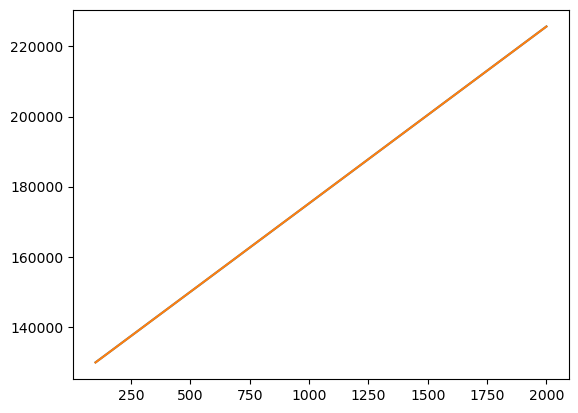

In [18]:
plt.plot(t,x)
plt.plot(t,124817+50.422*t)